Epoch 1/100
31/31 [==============================] - 1s 10ms/step - loss: 0.2434 - val_loss: 0.0057
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.0059
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0625 - val_loss: 0.0029
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0410 - val_loss: 4.5008e-04
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0362 - val_loss: 5.2590e-04
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0278 - val_loss: 4.6727e-04
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0248 - val_loss: 0.0015
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0196 - val_loss: 0.0032
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0165 - val_loss: 0.0023
Epoch 10/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0

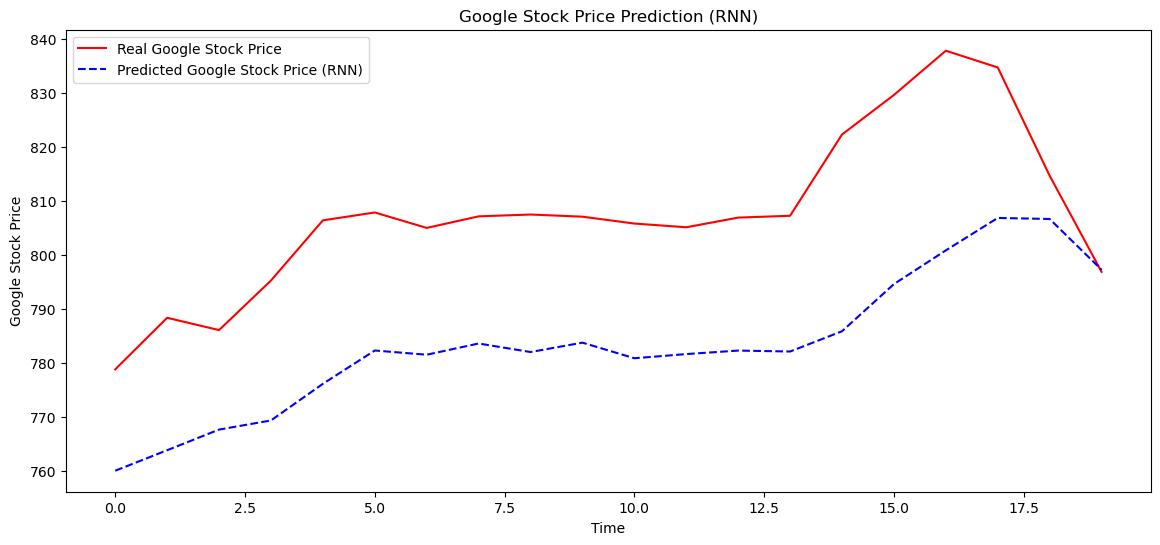

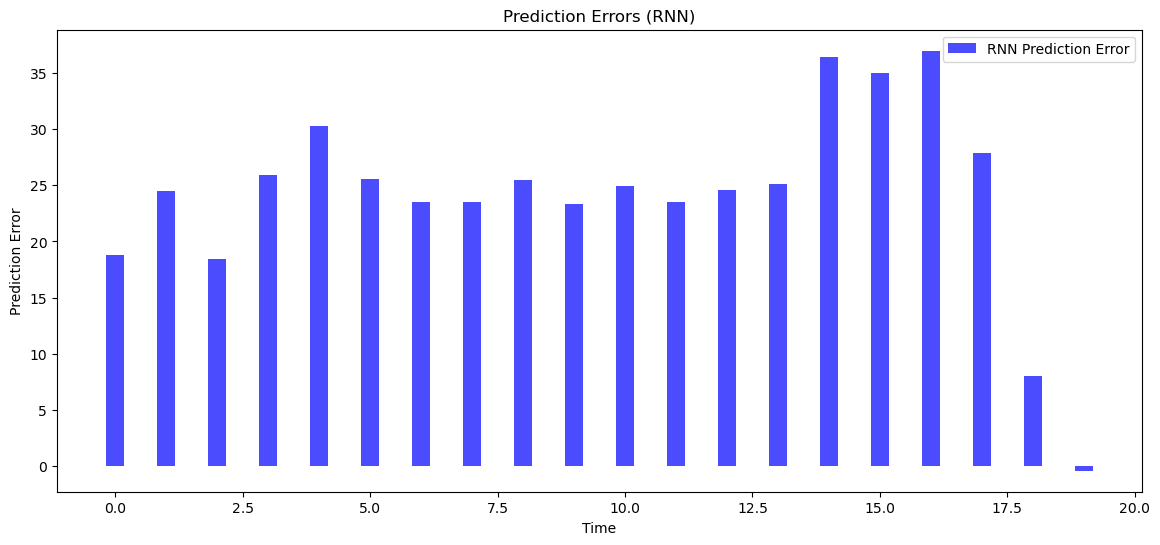

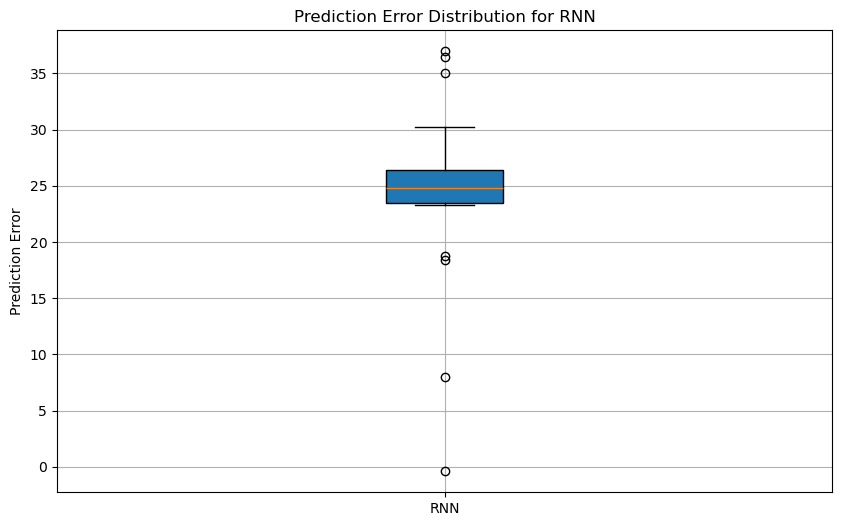

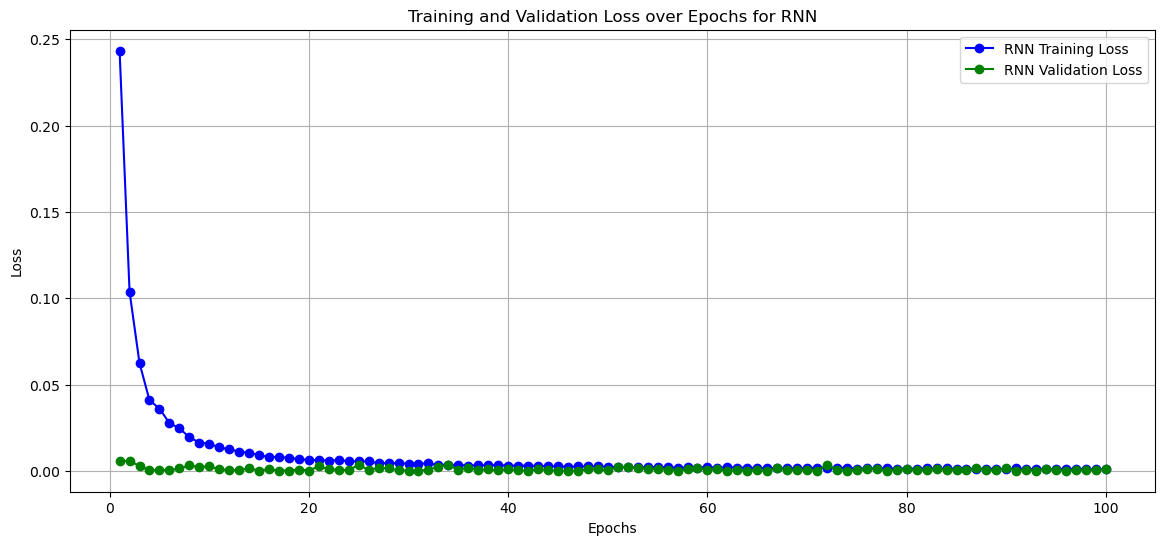

In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error

# 1. load dateset
dataset_train = pd.read_csv('/Users/jasper/Desktop/assignments/deep learning/Assignment3/archive/Google_Stock_Price_Train.csv')
dataset_test = pd.read_csv('/Users/jasper/Desktop/assignments/deep learning/Assignment3/archive/Google_Stock_Price_Test.csv')

dataset_train.replace(',', '', regex=True, inplace=True)
dataset_test.replace(',', '', regex=True, inplace=True)

# data pre_processing
# extract features：'Open', 'High', 'Low', 'Close', 'Volume'
training_set = dataset_train[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float).values
training_set = training_set.reshape(-1, 5)

scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)

# 0.8 train and 0.2 validation
train_size = int(len(training_set_scaled) * 0.8)
validation_size = len(training_set_scaled) - train_size
train_set, validation_set = training_set_scaled[:train_size], training_set_scaled[train_size:]

def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, :])
        y.append(data[i, 0])  # 预测 'Open' 价格
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_set, time_step=30)
X_val, y_val = create_dataset(validation_set, time_step=30)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2]))

# creat RNN model
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # 加入 Dropout 防止过拟合
model.add(SimpleRNN(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# prepare dataset
dataset_total = pd.concat((dataset_train[['Open', 'High', 'Low', 'Close', 'Volume']], dataset_test[['Open', 'High', 'Low', 'Close', 'Volume']]), axis=0)
dataset_total.replace(',', '', regex=True, inplace=True)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 30:].astype(float).values
inputs = scaler.transform(inputs)

# creat test dataset
X_test, y_test = create_dataset(inputs, time_step=30)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# prediction
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], 4))), axis=1))[:, 0]

# calculate（MSE）
mse_rnn = mean_squared_error(y_test, y_pred)
print(f"RNN Model MSE: {mse_rnn}")

# visulization
plt.figure(figsize=(14, 6))
plt.plot(dataset_test['Open'].astype(float).values, color='red', label='Real Google Stock Price')
plt.plot(y_pred, color='blue', linestyle='--', label='Predicted Google Stock Price (RNN)')
plt.title('Google Stock Price Prediction (RNN)')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# Plot a histogram of forecast error
errors_rnn = dataset_test['Open'].astype(float).values - y_pred
bar_width = 0.35
index = np.arange(len(y_pred))

plt.figure(figsize=(14, 6))
plt.bar(index, errors_rnn, bar_width, color='blue', alpha=0.7, label='RNN Prediction Error')
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.title('Prediction Errors (RNN)')
plt.legend()
plt.show()

# Draw a boxplot of the prediction results showing the error distribution
plt.figure(figsize=(10, 6))
plt.boxplot([errors_rnn], labels=['RNN'], patch_artist=True)
plt.title('Prediction Error Distribution for RNN')
plt.ylabel('Prediction Error')
plt.grid(True)
plt.show()

epochs = np.arange(1, len(history.history['loss']) + 1)
rnn_training_loss = history.history['loss']
rnn_val_loss = history.history['val_loss']

plt.figure(figsize=(14, 6))
plt.plot(epochs, rnn_training_loss, color='blue', linestyle='-', marker='o', label='RNN Training Loss')
plt.plot(epochs, rnn_val_loss, color='green', linestyle='-', marker='o', label='RNN Validation Loss')
plt.title('Training and Validation Loss over Epochs for RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/100


2024-11-30 17:34:12.219544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-30 17:34:12.220016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-30 17:34:12.220516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 2s 28ms/step - loss: 0.0112 - val_loss: 0.0016


2024-11-30 17:34:14.125084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-30 17:34:14.125618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-30 17:34:14.126245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0029 - val_loss: 8.6978e-04
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 7/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0025 - val_loss: 0.0055
Epoch 8/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 9/100
31/31 [==============================] - 1s 24ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 10/100
31/31 [==============================] - 1s 24ms/step - loss: 0.0023 - val_loss: 7.8020e-04
Epoch 11/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0021 - val_los

2024-11-30 17:35:25.917465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-30 17:35:25.918161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-30 17:35:25.918692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

LSTM Model MSE: 664506.1900390168


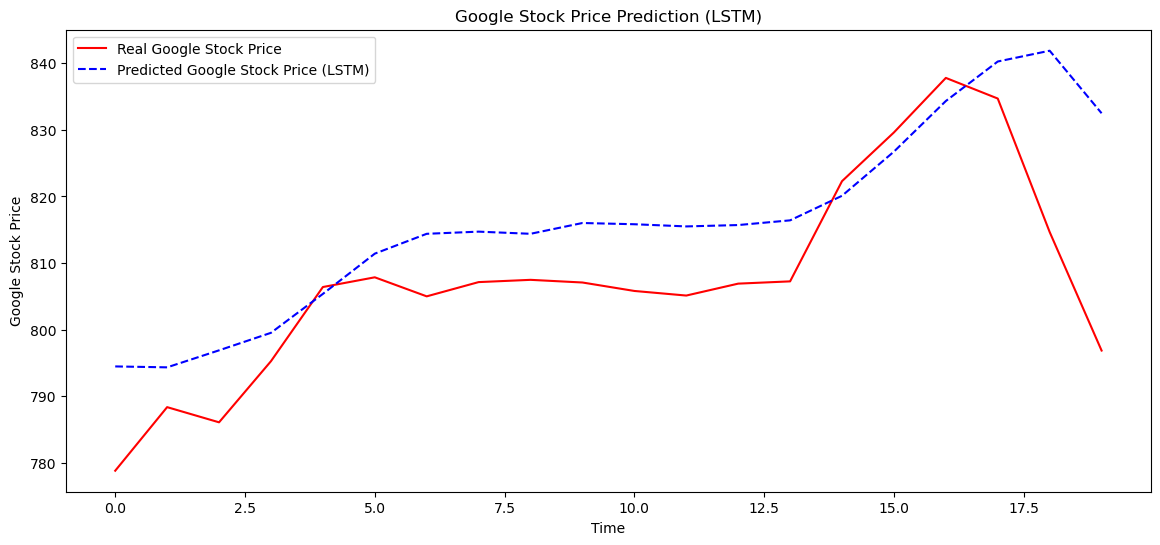

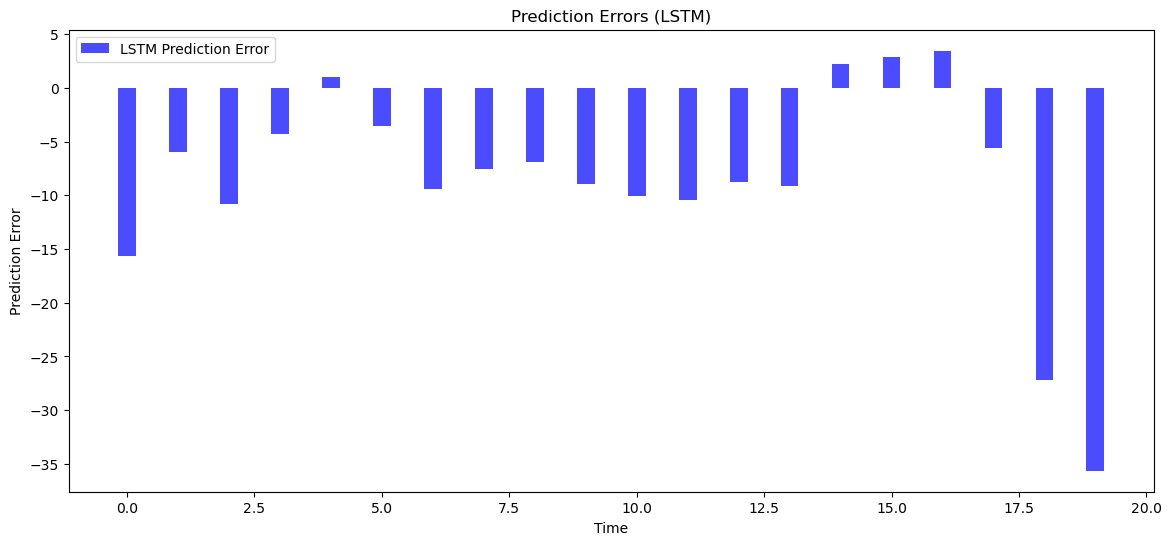

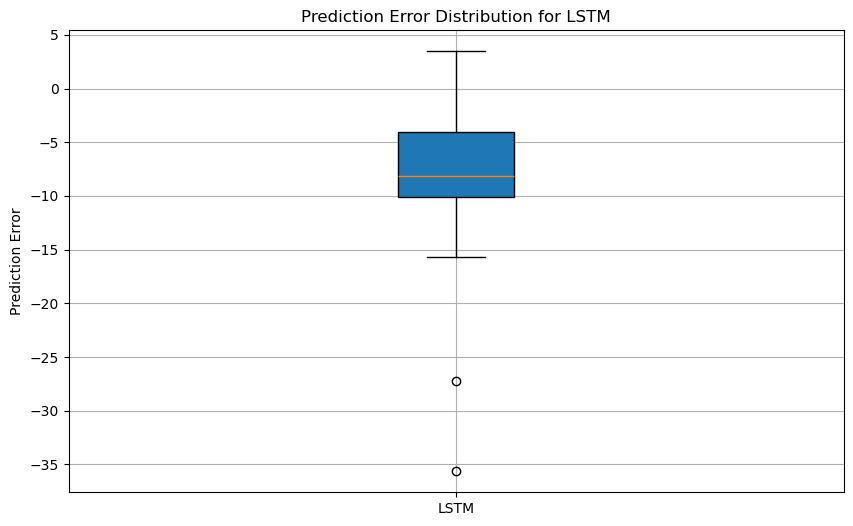

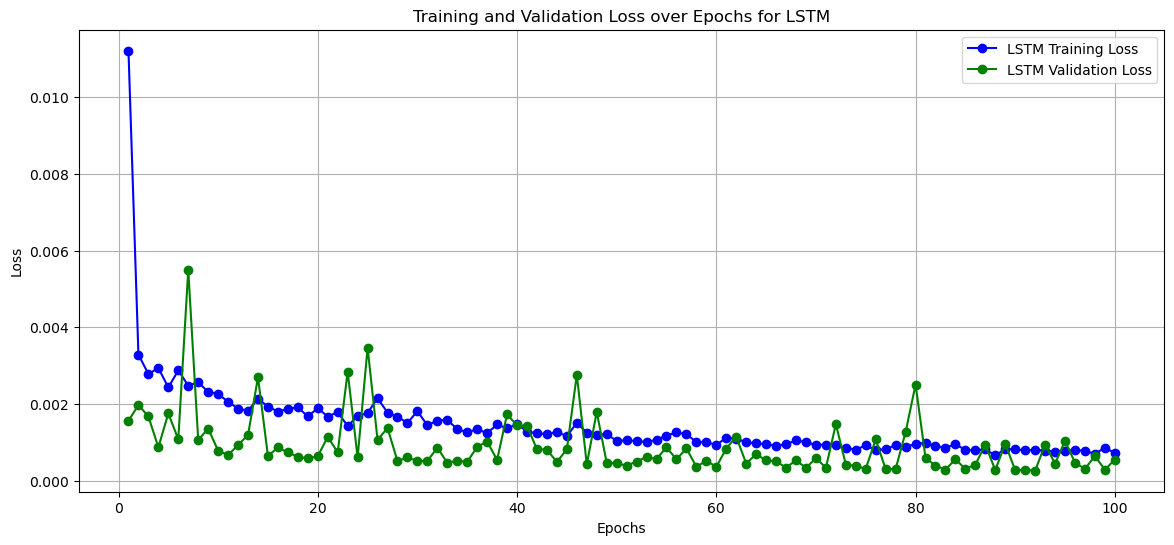

In [15]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

# 1. load dataset
dataset_train = pd.read_csv('/Users/jasper/Desktop/assignments/deep learning/Assignment3/archive/Google_Stock_Price_Train.csv')
dataset_test = pd.read_csv('/Users/jasper/Desktop/assignments/deep learning/Assignment3/archive/Google_Stock_Price_Test.csv')

dataset_train.replace(',', '', regex=True, inplace=True)
dataset_test.replace(',', '', regex=True, inplace=True)

# data pre_processing
# extract features：'Open', 'High', 'Low', 'Close', 'Volume'
training_set = dataset_train[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float).values
training_set = training_set.reshape(-1, 5)

scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)

# 0.8 train and 0.2 validation
train_size = int(len(training_set_scaled) * 0.8)
validation_size = len(training_set_scaled) - train_size
train_set, validation_set = training_set_scaled[:train_size], training_set_scaled[train_size:]

def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, :])
        y.append(data[i, 0])  # 预测 'Open' 价格
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_set, time_step=30)
X_val, y_val = create_dataset(validation_set, time_step=30)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2]))

# creat LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# prepare test dataset
dataset_total = pd.concat((dataset_train[['Open', 'High', 'Low', 'Close', 'Volume']], dataset_test[['Open', 'High', 'Low', 'Close', 'Volume']]), axis=0)
dataset_total.replace(',', '', regex=True, inplace=True)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 30:].astype(float).values
inputs = scaler.transform(inputs)

# creat test dataset
X_test, y_test = create_dataset(inputs, time_step=30)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# prediction
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], 4))), axis=1))[:, 0]

# calculate（MSE）
mse_lstm = mean_squared_error(y_test, y_pred)
print(f"LSTM Model MSE: {mse_lstm}")

# visulasation
plt.figure(figsize=(14, 6))
plt.plot(dataset_test['Open'].astype(float).values, color='red', label='Real Google Stock Price')
plt.plot(y_pred, color='blue', linestyle='--', label='Predicted Google Stock Price (LSTM)')
plt.title('Google Stock Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# Plot a histogram of forecast error
errors_lstm = dataset_test['Open'].astype(float).values - y_pred
bar_width = 0.35
index = np.arange(len(y_pred))

plt.figure(figsize=(14, 6))
plt.bar(index, errors_lstm, bar_width, color='blue', alpha=0.7, label='LSTM Prediction Error')
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.title('Prediction Errors (LSTM)')
plt.legend()
plt.show()

# Draw a boxplot of the prediction results showing the error distribution
plt.figure(figsize=(10, 6))
plt.boxplot([errors_lstm], labels=['LSTM'], patch_artist=True)
plt.title('Prediction Error Distribution for LSTM')
plt.ylabel('Prediction Error')
plt.grid(True)
plt.show()

epochs = np.arange(1, len(history.history['loss']) + 1)
lstm_training_loss = history.history['loss']
lstm_val_loss = history.history['val_loss']

plt.figure(figsize=(14, 6))
plt.plot(epochs, lstm_training_loss, color='blue', linestyle='-', marker='o', label='LSTM Training Loss')
plt.plot(epochs, lstm_val_loss, color='green', linestyle='-', marker='o', label='LSTM Validation Loss')
plt.title('Training and Validation Loss over Epochs for LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
